# Time Alignment

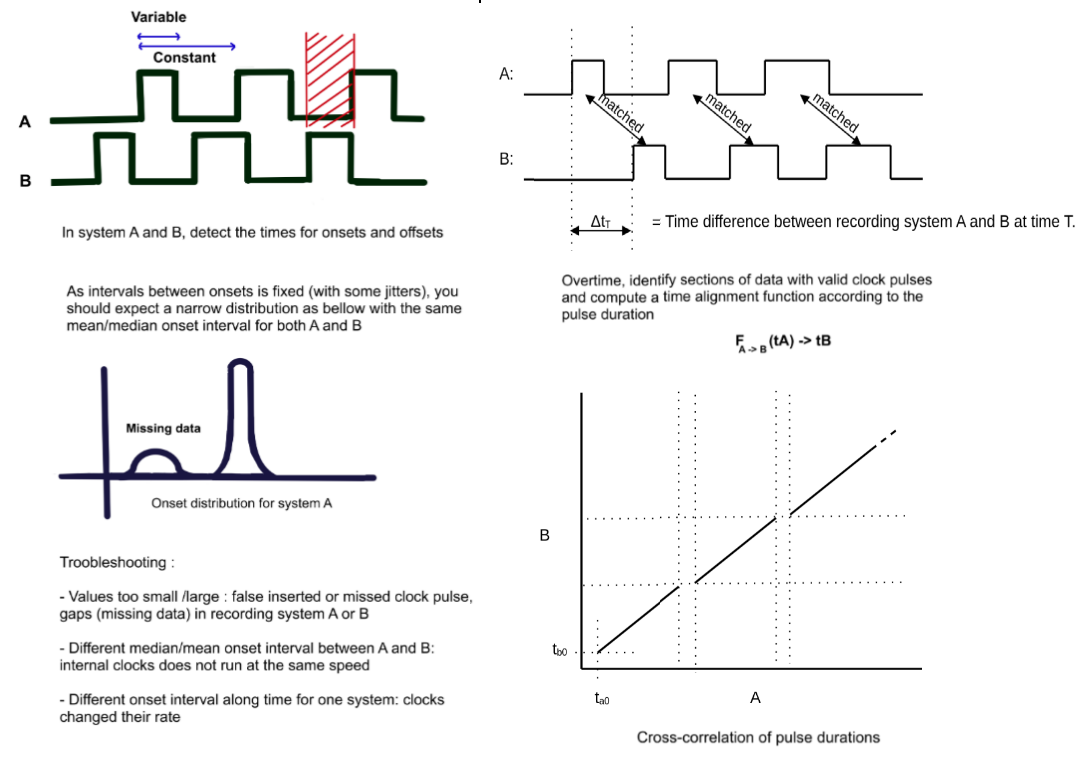


## Table of Content

1. Import
2. Example Data Case
3. Real Data Case
4. Code Snippet
5. N>2 Recording systems Case

## Import

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (16, 12)

from IPython.core.display import display, HTML

# import
from fklab.signals.time_alignment import *
from fklab.io.neuralynx.nlx_sync import nlx_retrieve_event, nlx_start_recording_time
from fklab.io.spikeGLX.glx_sync import glx_extra_sync_signal

### Example Data Case

Create two example sync data.

time_offset[A] = 0.0
time_offset[B] = 0.23422781422543293


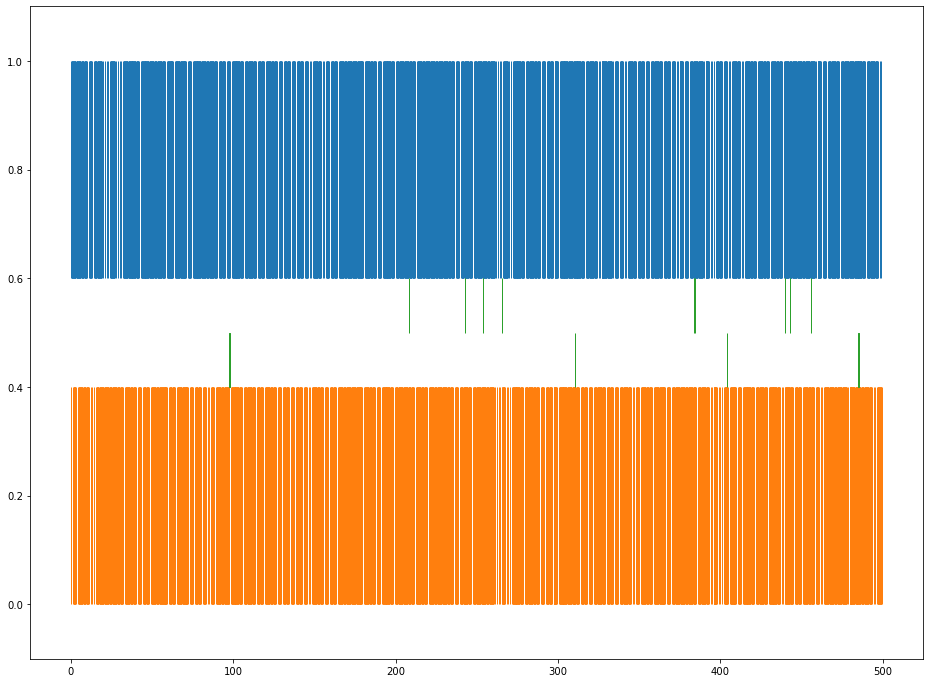

In [ ]:
time_duration = 500
sample_rate = 100
onset_interval = 1

rand_uniform_possible_range = (10, sample_rate * onset_interval // 2)  # dt
rand_uniform = RepeatRandomSequenceGenerator(
    lambda: np.random.randint(*rand_uniform_possible_range) / sample_rate
)

offset_a, sync_a, sync_a_missing, sync_a_noise = generate_example(
    time_duration,
    sample_rate,
    time_offset=0.0,  # set zero as reference
    onset_interval=onset_interval,
    offset_interval=rand_uniform.clear(),
    missing_rate=0.0,
    noise_rate=0.0,
)

offset_b, sync_b, sync_b_missing, sync_b_noise = generate_example(
    time_duration,
    sample_rate,
    #     time_offset=0.0, # set zero to debug generate_example
    onset_interval=onset_interval,
    offset_interval=rand_uniform.reset(),
    missing_rate=0.01,
    noise_rate=0.01,
)

print(f"time_offset[A] = {offset_a}")
print(f"time_offset[B] = {offset_b}")

plot_sync_pulse(sync_a, (0.6, 0.4), color="C0", ax=plt.gca())
plot_sync_pulse(sync_b, (0, 0.4), color="C1", ax=plt.gca())
plot_sync_pulse(sync_b_missing, (0.4, 0.1), color="C2", is_gap=True, ax=plt.gca())
plot_sync_pulse(sync_b_noise, (0.5, 0.1), color="C2", is_gap=True, ax=plt.gca())
plt.ylim(-0.1, 1.1);

Create TimeAlignment

In [ ]:
ta = TimeAlignment("A", sync_a, "B", sync_b)

### pulse validating

#### onset interval

distribution of onset interval.

''

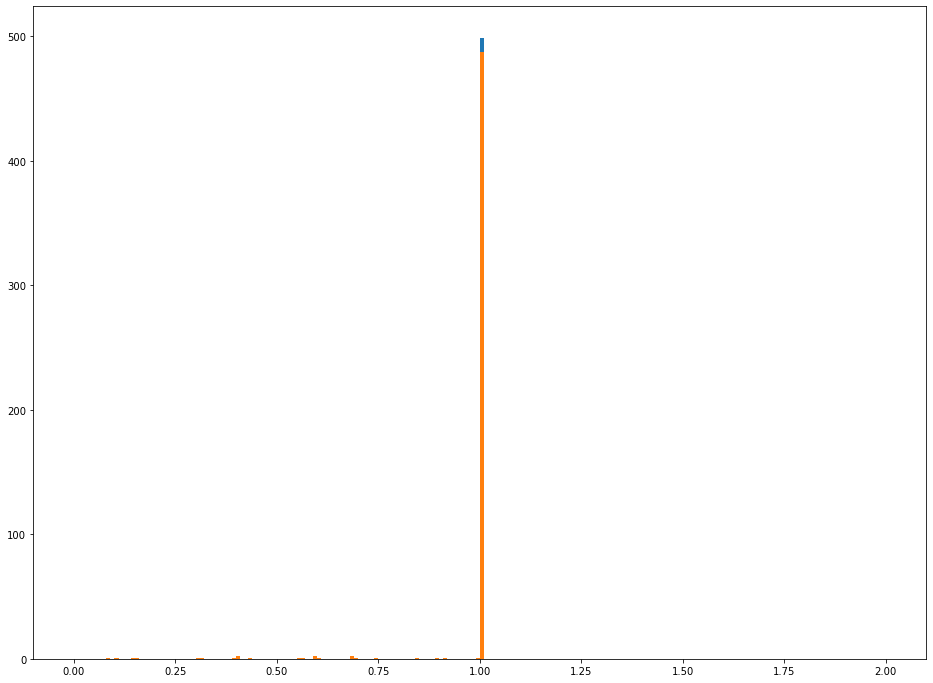

In [ ]:
onset_int_a = np.diff(sync_a[:, 0])
onset_int_b = np.diff(sync_b[:, 0])

plt.hist(onset_int_a, range=(0, onset_interval * 2), bins=2 * sample_rate)
plt.hist(onset_int_b, range=(0, onset_interval * 2), bins=2 * sample_rate);

distribution of onset with threshold

interval[A]=(1.0, nan)
interval[B]=(1.0, nan)


''

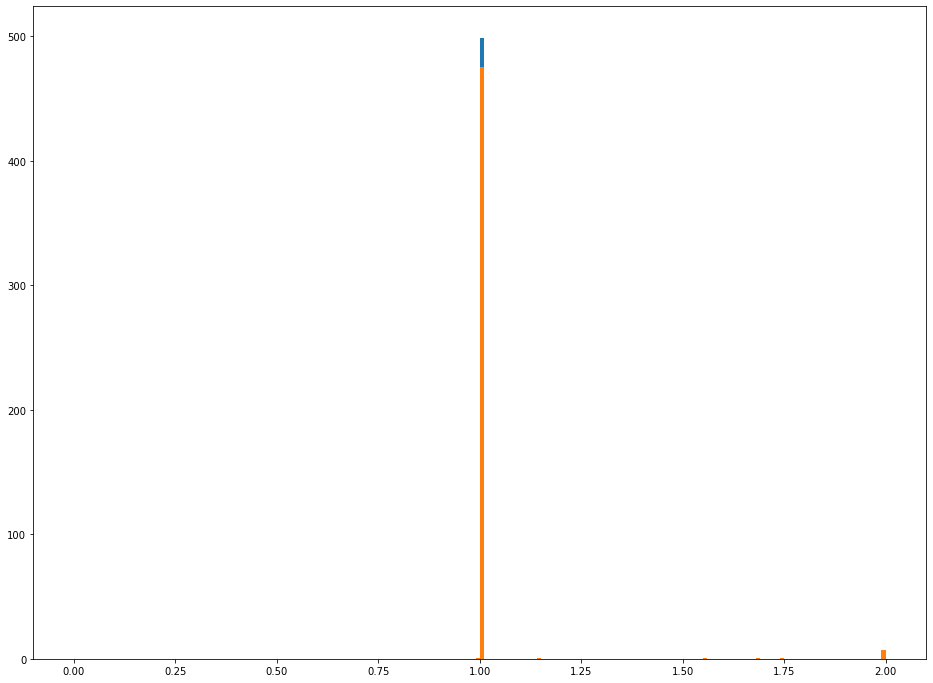

In [ ]:
sync_a_th = ta.get_sync_valid("A")
sync_b_th = ta.get_sync_valid("B")

onset_a_th_diff = np.diff(sync_a_th[:, 0])
onset_b_th_diff = np.diff(sync_b_th[:, 0])

plt.hist(onset_a_th_diff, range=(0, onset_interval * 2), bins=2 * sample_rate)
plt.hist(onset_b_th_diff, range=(0, onset_interval * 2), bins=2 * sample_rate)

onset_a_interval = np.median(onset_a_th_diff)
onset_b_interval = np.median(onset_b_th_diff)
print(f'interval[A]={ta.get_sync_pulse("A")}')
print(f'interval[B]={ta.get_sync_pulse("B")}');

show onset interval along time

In [ ]:
plt.plot(sync_a_th[:-1, 0], onset_a_th_diff)
plt.plot(sync_b_th[:-1, 0], onset_b_th_diff, color="C1")
plt.plot(sync_b[:-1, 0], onset_int_b, color="C1", ls=":")
plot_sync_pulse(sync_b_missing, (0.0, 0.1), color="k", is_gap=True, ax=plt.gca())
plot_sync_pulse(sync_b_noise, (0.1, 0.1), color="k", is_gap=True, ax=plt.gca());

''

#### offset pulse width

distribution of offset interval

''

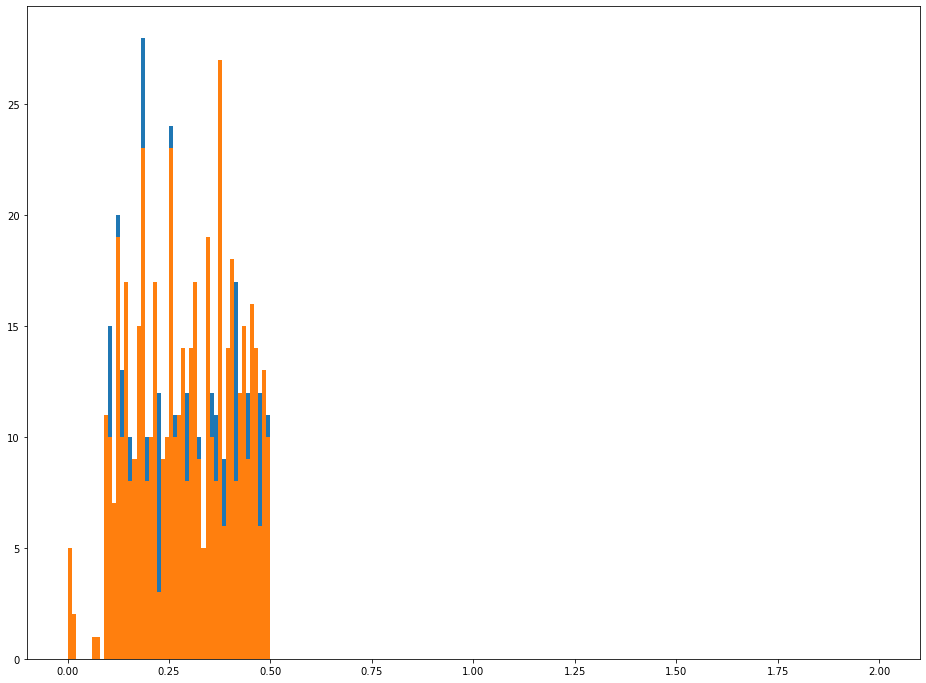

In [ ]:
offset_a_diff_ = sync_a[:, 1] - sync_a[:, 0]
offset_b_diff_ = sync_b[:, 1] - sync_b[:, 0]

plt.hist(offset_a_diff_, range=(0, onset_interval * 2), bins=2 * sample_rate)
plt.hist(offset_b_diff_, range=(0, onset_interval * 2), bins=2 * sample_rate);
# TODO check dist, not look uniform

distribution of offset with unexpected pulse removed

In [ ]:
offset_a_diff = sync_a_th[:, 1] - sync_a_th[:, 0]
offset_b_diff = sync_b_th[:, 1] - sync_b_th[:, 0]

plt.hist(offset_a_diff, range=(0, onset_interval * 2), bins=2 * sample_rate)
plt.hist(offset_b_diff, range=(0, onset_interval * 2), bins=2 * sample_rate);

''

offset width along time

In [ ]:
plt.plot(sync_a_th[:, 0], offset_a_diff)
plt.plot(sync_b_th[:, 0], offset_b_diff, color="C1")
plt.plot(sync_b[:, 0], offset_b_diff_, color="C1", ls=":")
plot_sync_pulse(sync_b_missing, (0.0, 0.05), color="k", is_gap=True, ax=plt.gca())
plot_sync_pulse(sync_b_noise, (0.0, 0.05), color="k", is_gap=True, ax=plt.gca());

''

Get segments/gaps from TimeAlignment.

In [ ]:
gap_bt = ta.get_sync_gap("B")
seg_bt = ta.get_sync_segment("B")

if len(gap_bt) > 0:

    _missing_table = sync_b_missing.copy()  # (time_stamp, time_duration)
    _missing_table[:, 1] += _missing_table[:, 0]  # (time_start, time_end)

    display(
        HTML(
            f"""
        <table>
        <tr>
            <th>B segment time</th>
            <th>B gap time</th>
            <th>B noise time</th>
            <th>B missing time</th>
        </tr>
        <tr>
        <td><pre>{seg_bt}</pre></td>
        <td><pre>{gap_bt}</pre></td>
        <td><pre>{sync_b_noise[:, 0][:, None]}</pre></td>
        <td><pre>{_missing_table}</pre></td>
        </tr>
        </table>
        """
        )
    )

put together

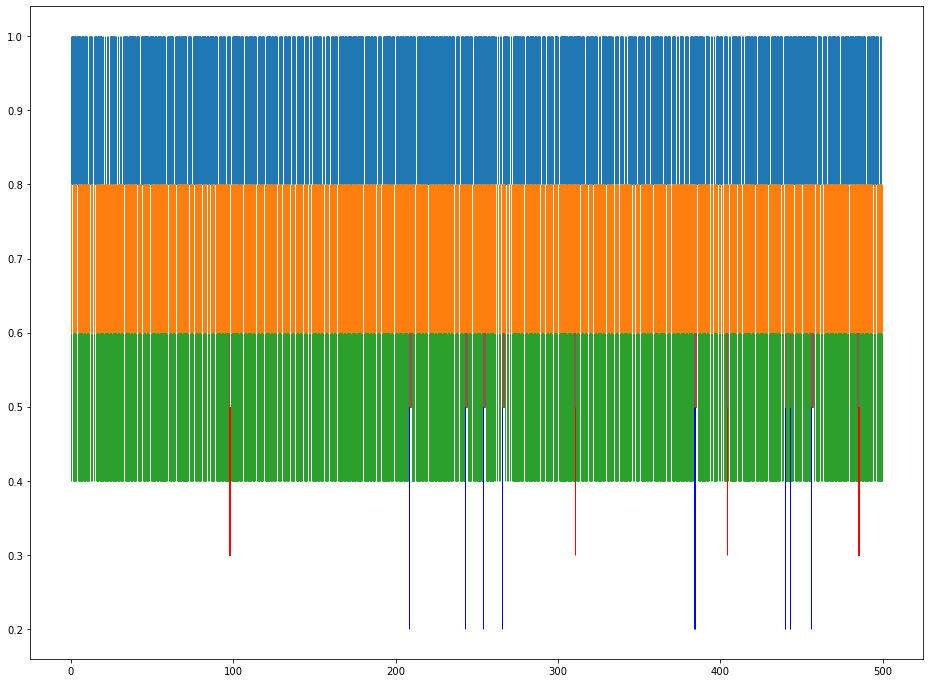

In [ ]:
plot_sync_pulse(sync_a, (0.8, 0.2), color="C0", ax=plt.gca())  # reference
plot_sync_pulse(sync_b, (0.6, 0.2), color="C1", ax=plt.gca())  # raw signal
plot_sync_pulse(sync_b_th, (0.4, 0.2), color="C2", ax=plt.gca())  # valided signal
plot_sync_pulse(gap_bt, (0.5, 0.1), color="C5", ax=plt.gca())  # gap segment
plot_sync_pulse(
    sync_b_missing, (0.3, 0.2), color="r", is_gap=True, ax=plt.gca()
)  # real missing
plot_sync_pulse(
    sync_b_noise, (0.2, 0.3), color="b", is_gap=True, ax=plt.gca()
)  # real noise
# plt.grid(axis='x', which='major')
# plt.xlim((0, 17))

### Time Alignment

plotting time alignment result. Horizontal line and vertical lines mean the gap and missing in recording B and A,
respectively.

In [ ]:
plot_time_alignment_result(
    ta,
    "A",  # x-axis
    "B",  # y-axis
)

compute average time offset

In [ ]:
time_offset, offset_std = ta.avg_time_offset("B")
time_offset_real = offset_b - offset_a
print(f"time offset = {time_offset}, std= {offset_std}")
print(f"read time_offset = {time_offset_real}")
print(
    f"difference = {100 * (time_offset - time_offset_real) / (1/sample_rate)}% 1/sample_rate"
)
# When missing happen, it will change time offset in each segment,
# so time_offset wouldn't match to the time_offset_real.

time offset = -0.6675704989153987, std= 0.5418800704552424
read time_offset = 0.23422781422543293
difference = -9017.983131408315% 1/sample_rate


This value (average time offset) is not a good way to be used to time alignment between two recording 
systems. The better way is using time mapping function, which will be introduced in following port,
to do the time alignment, and it is more powerful.

### Time Mapping Function

300.38


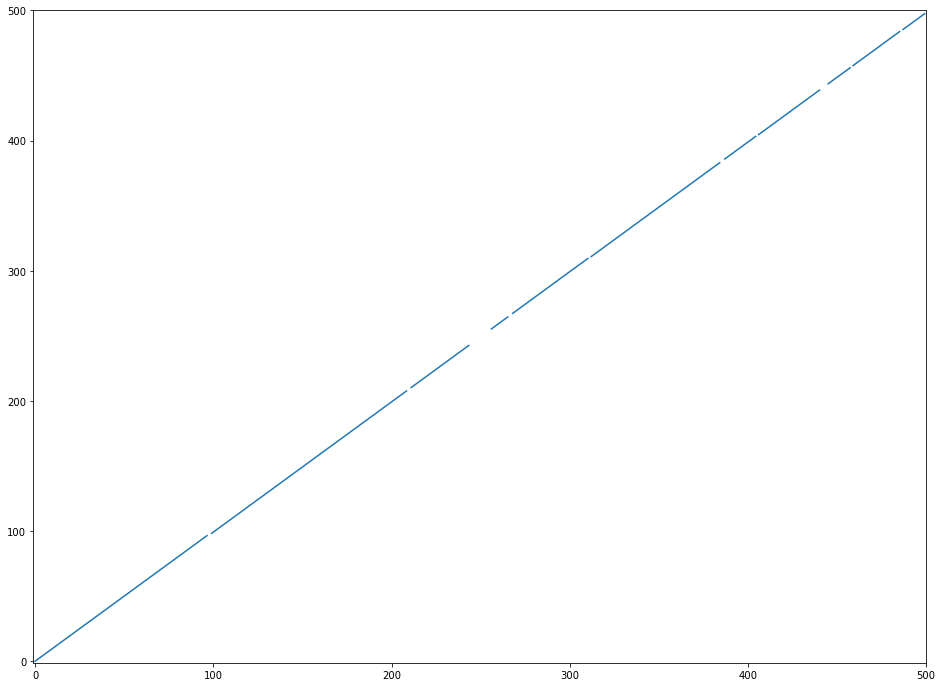

In [ ]:
# mapping from A to B
f = ta.time_map("B")

x = np.linspace(-10, time_duration, num=time_duration * sample_rate + 10)
y = f(x)

plt.plot(x, y)
plt.xlim((-1, time_duration))
plt.ylim((-1, time_duration))

print(ta.time_map("B", 301))

The signature of the method `time_map` is little complex, here list all possible form:

* `time_map(B_label) -> fab`

  N=2 recording system case. return a function `(A_time) -> B_time`

* `time_map(B_label, A_time) -> B_time`

  N=2 recording system case. return B_time

* `time_map(A_label, B_label) -> fab`

  N>2 recording system case. return a function `(A_time) -> B_time`

* `time_map(A_label, A_time, B_label) -> B_time`

  N>2 recording system case. return B_time
    
where `*_time` type mapping rule:

* `(int|float) -> float`
* `(tuple|list|numpy.ndarray) -> numpy.ndarray` the shape of output as same as input's
* `(Segment) -> Segment`

The following code do the same thing:

* N=2 recording system case.

      ta.time_map('B')(t_A) == ta.time_map('B', t_A)
      
* N>2 recording system case.

      ta.time_map('A', 'B')(t_A) == ta.time_map('A', t_A, 'B')

## Real Data Case

### loading data

Neuralynx data

In [ ]:
nlx_file = Path(".../neuralynx/Events.nev")
nlx_data = nlx_retrieve_event(nlx_file) - nlx_start_recording_time(nlx_file)
# If you don't use "Start Recording" event as time 0,
# please remove nlx_start_recording_time

Neuropixels

In [ ]:
glx_file = Path(".../neuropixels/***_g0_t0.imec0.lf.bin")
glx_data = glx_extra_sync_signal(glx_file)

Create Time alignment result. here use another style to create a TimeAlignment instance.

In [ ]:
ta = TimeAlignment({"nlx": nlx_data, "npx": glx_data})

Save and load to/from file.

In [ ]:
# TA.save('test.h5')
ta = TimeAlignment.load("test.h5")

It is better that you call `sync_index_alignment` or `sync_time_alignment` to trigger time alignment 
for certain two recording systems, before you save the result. Otherwise, the alignment result 
wouldn’t be saved, and the alignment result is recalculate for every time you use it.



### data health checking

This part include how to use data included in TimeAlignment.

In [ ]:
sync_nlx = ta.get_sync_raw("nlx")
sync_npx = ta.get_sync_raw("npx")

sync_nlx_onset_int = np.diff(sync_nlx[:, 0])
sync_npx_onset_int = np.diff(sync_npx[:, 0])

# bin_range = (0.998, 1.002)
bin_range = (0, 1.5)
plt.hist(sync_nlx_onset_int, range=bin_range, bins=100, alpha=0.5, log=True)
plt.hist(sync_npx_onset_int, range=bin_range, bins=100, alpha=0.5, log=True)


print(
    f"range[0-100][nlx]= ({np.min(sync_nlx_onset_int):.2f}, {np.max(sync_nlx_onset_int):.2f})"
)
print(
    f"range[0-100][npx]= ({np.min(sync_npx_onset_int):.2f}, {np.max(sync_npx_onset_int):.2f})"
)
print(
    "range[30-70][nlx]=",
    tuple(map(lambda it: round(it, 2), np.percentile(sync_nlx_onset_int, (30, 70)))),
)
print(
    "range[30-70][npx]=",
    tuple(map(lambda it: round(it, 2), np.percentile(sync_npx_onset_int, (30, 70)))),
)

invalid_nlx_ratio = 100 * len(ta.get_sync_gap("nlx")) / len(sync_nlx)
invalid_npx_ratio = 100 * len(ta.get_sync_gap("npx")) / len(sync_npx)

print(
    f'median_interval[nlx]= {ta.get_sync_pulse("nlx")}, invalid={invalid_nlx_ratio:.2}%'
)
print(
    f'median_interval[npx]= {ta.get_sync_pulse("npx")}, invalid={invalid_npx_ratio:.2}%'
);
# plt.show()

range[0-100][nlx]= (0.04, 1.07)
range[0-100][npx]= (1.00, 1.00)
range[30-70][nlx]= (1.0, 1.0)
range[30-70][npx]= (1.0, 1.0)
median_interval[nlx]= (0.9999678134918213, nan), invalid=0.027%
median_interval[npx]= (1.0, nan), invalid=0.0%


''

offset width distribution

In [ ]:
sync_nlx_offset_int = sync_nlx[:, 1] - sync_nlx[:, 0]
sync_npx_offset_int = sync_npx[:, 1] - sync_npx[:, 0]

print(np.min(sync_nlx_offset_int), np.max(sync_nlx_offset_int))
print(np.min(sync_npx_offset_int), np.max(sync_npx_offset_int))

plt.hist(sync_nlx_offset_int, range=(0, 2), bins=100, alpha=0.3)
plt.hist(sync_npx_offset_int, range=(0, 2), bins=100, alpha=0.3);

9.298324584960938e-05 0.49887514114379883
0.0999999999994543 0.4992000000002008


''

gap detection along time

[[5.81459904e+00 5.92166114e+00]
 [7.28799141e+03 7.28802791e+03]]
[]


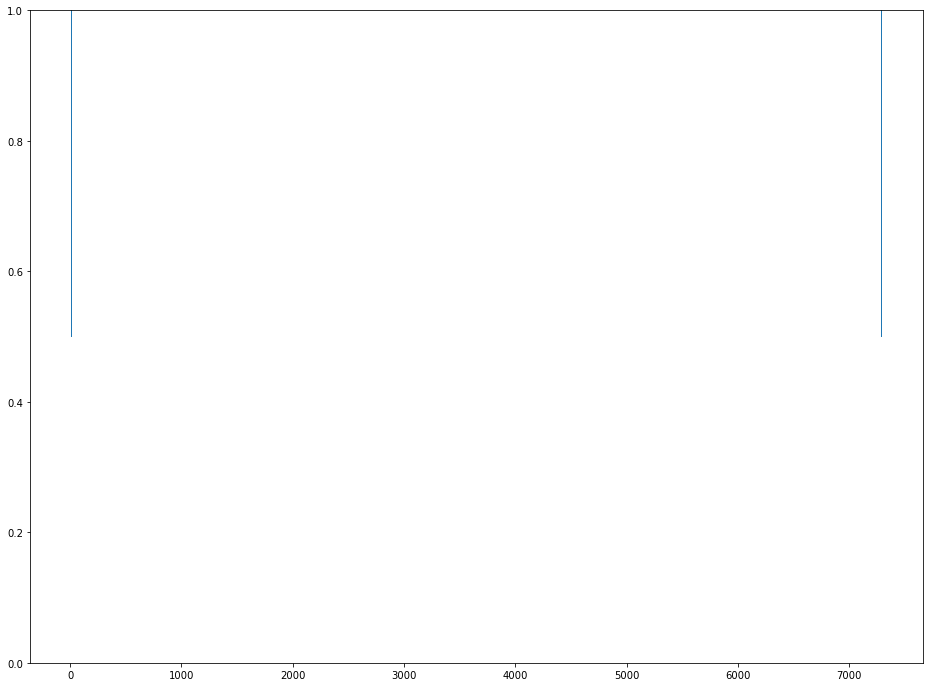

In [ ]:
plot_sync_pulse(ta.get_sync_gap("nlx"), (0.5, 0.5), ax=plt.gca(), min_width=10)
plot_sync_pulse(ta.get_sync_gap("npx"), (0.0, 0.5), ax=plt.gca(), min_width=10)
plt.ylim(0, 1)
("")
print(ta.get_sync_gap("nlx"))
print(ta.get_sync_gap("npx"))

### Time Alignment


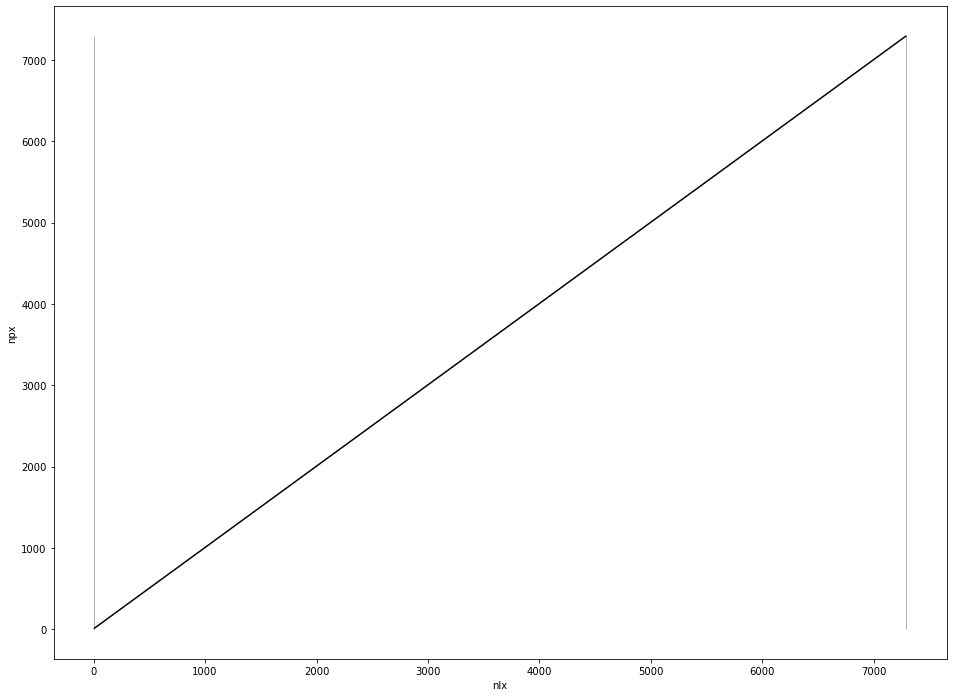

In [ ]:
ta.sync_index_alignment("nlx", "npx", force=True)
plot_time_alignment_result(ta, "nlx", "npx", ax=plt.gca())

time mapping from nlx to npx

''

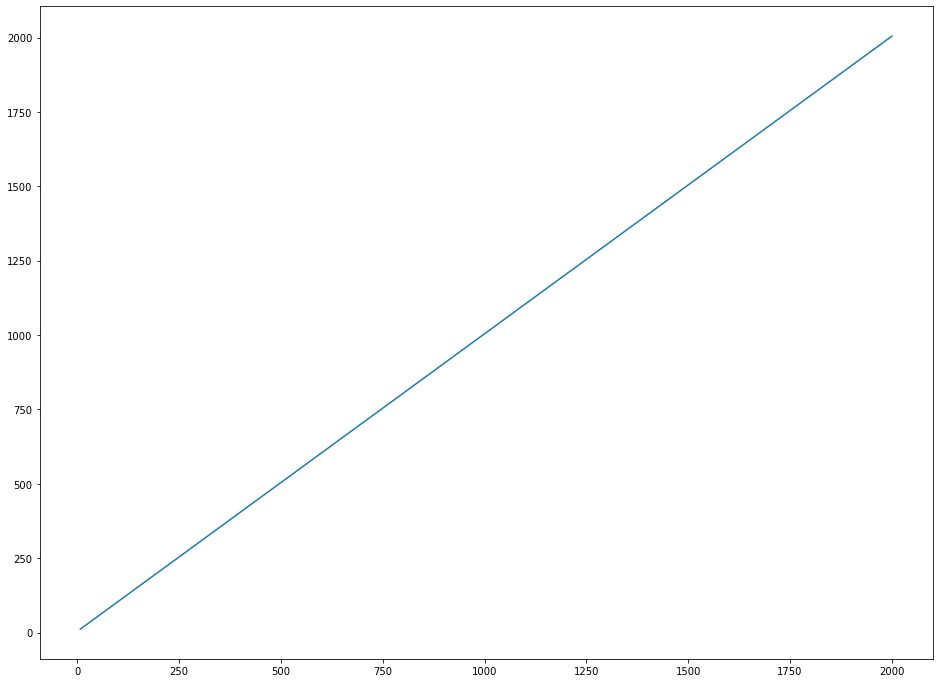

In [ ]:
f = ta.time_map("npx")

x = np.linspace(0, 2000, num=2000)
y = f(x)

plt.plot(x, y);

average time offset

In [ ]:
ta.avg_time_offset("npx")
# the first value is overall average time offset between two recording systems
# the second value is STD.

(4.6336395083558335, 0.0005826136939522926)

## Code Snippet

Retrieve sync data from Neuralynx.

**NOTICE** If you have complex setup, that nlx_retrieve_event will raise an error. In this case, you need to provide event_config.yaml file by module nlx_config.

In [ ]:
from fklab.io.neuralynx.nlx_sync import nlx_retrieve_event, nlx_start_recording_time

# load Neuralynx data
nlx_file = Path(".../neuralynx/Events.nev")
nlx_data = nlx_retrieve_event(nlx_file) - nlx_start_recording_time(nlx_file)
# If you don't use "Start Recording" event as time 0,
# please remove nlx_start_recording_time

retrieve sync data from Neuropixles/Glx

In [ ]:
from fklab.io.spikeGLX.glx_sync import glx_extra_sync_signal

glx_file = Path('.../neuropixels/***_g0_t0.imec0.lf.bin')
glx_data = glx_extra_sync_signal(glx_file)

# you can concatnate interrupted data.
glx_data = glx_extra_sync_signal(
    '.../s0/neuropixels/***_g0_t0.imec0.lf.bin',
    '.../s1/neuropixels/***_g0_t0.imec0.lf.bin',
    '.../s2/neuropixels/***_g0_t0.imec0.lf.bin,
)



You have a run period Segment, and you want to known the LFP data during this period.

In [ ]:
run_segment = Segment.fromlogical(...)

# map into Neuropixels time
run_segment_npx = TA.time_map("npx", run_segment)

# use it to fetch LFP data
lfp_data: np.ndarray  # with shape (channel, total_steps)
lfp_sample_rate = 2500  # you should get this value from meta file

lfp_run = []
for t1, t2 in run_segment_npx:
    # map from time second to time steps
    t = slice(int(t1 * lfp_sample_rate), int(t2 * lfp_sample_rate))
    lfp_run.append(lfp_data[:, t])

lfp_run = np.vstack(lfp_run)

work with Kilosort

In [ ]:
from fklab.spikes.Kilosort.utilities_kilosort import KiloSortResult

ks = KiloSortResult(".../params.py")  # load kilosort result

spike_t = {}
for cl in ks.get_good_cluster_group():
    spike_t[cl] = ta.time_map(
        "nlx", ks.time_sec(ks.get_spike_time(ks.get_spike_for_cluster(cl)))
    )

Example usage in notebook working flow.

**NOTICE** make sure the file contains enough informations that the alignment result
won't be overwrote or mis-loaded under different conditions.

In [ ]:
align_file = Path("result.h5")

if align_file.exists():
    ta = TimeAlignment.load(align_file)
else:
    # load Neuralynx data
    nlx_file = Path(".../neuralynx/Events.nev")
    nlx_data = nlx_retrieve_event(nlx_file) - nlx_start_recording_time(nlx_file)

    # load Neuropixels data
    glx_file = Path(".../neuropixels/***_g0_t0.imec0.lf.bin")
    glx_data = glx_extra_sync_signal(glx_file)

    # here use another style to create a TimeAlignment instance.
    ta = TimeAlignment({"nlx": nlx_data, "npx": glx_data})

    # trigger time alignment, and exam whether the value make sense or not.
    print(ta.avg_time_offset("npx"))

    # save into file
    ta.save(align_file)

## N>2 Recording systems Case

Here just show the difference from the previous example.

1. Create

In [ ]:
ta = TimeAlignment("A", data_a, "B", data_b, "C", data_c)  # vararg style, or
ta = TimeAlignment({"A": data_a, "B": data_b, "C": data_c})  # dict style

2. time mapping function

You need to specific the source/from_label and destination/to_label.

In [ ]:
fab = ta.time_map("A", "B")
t_b = ta.time_map("A", t_a, "B")